# Training linear nets

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from mpl_toolkits import mplot3d

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [3]:
def rep_error_deep_decoder(img_np,net,net_input,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    rnd = 500
    numit = 2500
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)


def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def comparison(img_np,net,net_input,convert2ycbcr=False):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np,net=net,net_input=net_input,convert2ycbcr=convert2ycbcr)
    nchannels = img_np.shape[0]
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
    #save_np_img(img_np,"exp_comp_orig.png")
    #save_np_img(out_img_np,"exp_comp_dd.png")
    
    plt.axis('off')
    fig.show()
    
def plot_kernels(tensor):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
    num_kernels = tensor.shape[0]
    fig = plt.figure(figsize=(tensor.shape[0],tensor.shape[1]))
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax1 = fig.add_subplot(tensor.shape[0],tensor.shape[1],1+i*tensor.shape[0]+j)
            ax1.imshow(tensor[i][j])
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def apply_until(net_input,net,n = 100):
    # applies function by funtion of a network
    for i,fun in enumerate(net):
        if i>=n:
            break
        if i==0:
            out = fun(net_input.type(dtype))
        else:
            out = fun(out)
    print(i, "last func. applied:", net[i-1])
    if n == 0:
        return net_input
    else:
        return out

def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

## Individual batch norm implementation

In [4]:
def pure_batch_norm(X, gamma, beta, eps = 1e-5):
    if len(X.shape) not in [4]:
        raise ValueError('only supports 2dconv')
    # extract the dimensions
    N, C, H, W = X.shape
    # mini-batch mean
    mean = torch.mean(X, axis=(0, 2, 3))
    # mini-batch variance
    variance = torch.mean((X - mean.reshape((1, C, 1, 1))) ** 2, axis=(0, 2, 3))
    # normalize
    X_hat = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.sqrt(variance.reshape((1, C, 1, 1)) + eps)
    # scale and shift
    return gamma.reshape((1, C, 1, 1)) * X_hat + beta.reshape((1, C, 1, 1))



class ChannelNormalization(torch.nn.Module):
    def __init__(self, D_in,mode="BN"):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        self.mode = mode
        requires_grad=True
        super(ChannelNormalization, self).__init__()
        #self.gamma = Variable(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = Variable(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        #self.gamma = nn.Parameter(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = nn.Parameter(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))

        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        #return (x - torch.mean(x))/(torch.std(x) + 0.00000001 ) *self.gamma[0] + self.beta[0]
        
        #return pure_batch_norm(x, self.gamma, self.beta, eps = 1e-5)
        
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[:,i] = (x[:,i] - torch.mean(x[:,i]))/(torch.std(x[:,i]) + 0.00000001 ) *g + b
                #print(torch.mean(x[0][i]))
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0]))/(torch.std(x[0]) + 0.00000001 ) *g + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "none":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize+bias":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                #xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( x[:,i] - torch.mean(x[:,i]) )  - torch.min( x[:,i] - torch.mean(x[:,i]) ) )
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "noise":
                #   noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
                #no = torch.norm(x[0][i].data)
                #sigma = 0.1*no
                #noise = Variable( torch.randn( x[0][i].size() ) * sigma ).type(dtype)
                #noise = Variable( x[0][i].data.new(x[0][i].size()).normal_(0, sigma))
                xx[0][i] = x[0][i] / ( torch.norm(x[0][i])* np.prod(x[0][i].shape) + 0.00001  ) + b
                #xx[0][i] = x[0][i] / torch.norm( x[0][i] )  + noise + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i])) / torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            #elif self.mode == "center_then_normalize": # stupid; is the same as BN
            #    center =  (x[0][i] - torch.mean(x[0][i]))
            #    xx[0][i] = center / torch.sqrt( torch.var(center) + 0.00001 ) + b
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            else:
                raise ValueError('not an option for channel normalization.')


        #x = x*self.gamma[0] + self.beta[0]
        return xx

In [5]:
#m = ChannelNormalization(4)
#m.parameters()
#print('m', list(m.parameters()))

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_uniform(m.weight)

# use the modules apply function to recursively apply the initialization
#rand_net.apply(init_normal)

## Decoder with channel normalization

In [6]:
def conv(in_f, out_f, kernel_size, stride=1, pad='zero',bias=False):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)


class normalizedconv(nn.Module):
    def __init__(self,in_f, out_f, kernel_size, stride, pad, bias):
        super(normalizedconv, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride, pad, bias)
    def forward(self,x):
        xx = self.conv(x)
        nchannels = self.conv[1].weight.shape[0]
        for i in range(nchannels):
            xx[:,i] /= torch.norm( self.conv[1].weight[i],p=2 )
        return xx

#          self.conv1.weight /=torch.norm(self.conv1.weight, p=2, 1,keepdim=True)
#          output = self.conv1(input)

def decnet(
        num_output_channels=3, 
        num_channels_up=[128]*5, 
        filter_size_up=1,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "none",
        upsample = False,
        nonlin = False,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    # print("generated net with mode ", mode)
    for i in range(len(num_channels_up)-1):
        if mode=="channeln":
            model.add(normalizedconv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        
        else:
            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        

        if nonlin:
            model.add(act_fun)
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True))
        if mode!= "channeln":
            model.add(ChannelNormalization(num_channels_up[i+1],mode=mode))
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True,track_running_stats=False,momentum=0))                 
        if upsample:
            model.add(nn.Upsample(scale_factor=2, mode="bilinear"))
    
    model.add(conv( num_channels_up[-1], num_output_channels, 1, pad='reflection',bias=True))
    model.add(nn.Sigmoid())
    
    return model

In [7]:
path = './test_data/'
img_name = "phantom256"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np = img_np[:,0:64,0:64]
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)
print(img_var.shape)

torch.Size([1, 1, 64, 64])


In [11]:
#### Load all the variables

num_channels = [8]*5
output_depth = 1

## network with normal initialization
net = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_Model_State.t7')
net.load_state_dict(net_state['state_dict'])

## network with alternative initialization that gives good convergence performance. In the following part, I will show 
## how to get the good initialization
net_new_initial = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_new_initial_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_new_initial_Model_State.t7')
net_new_initial.load_state_dict(net_new_initial_state['state_dict'])

## deep decoder networks that define the random directions 
net_dir1 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_dir1_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir1_Model_State.t7')
net_dir1.load_state_dict(net_dir1_state['state_dict'])

net_dir2 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_dir2_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir2_Model_State.t7')
net_dir2.load_state_dict(net_dir2_state['state_dict'])

net_dir3 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_dir3_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir3_Model_State.t7')
net_dir3.load_state_dict(net_dir3_state['state_dict'])

net_dir4 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
net_dir4_state = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir4_Model_State.t7')
net_dir4.load_state_dict(net_dir4_state['state_dict'])

### Network input
net_input = torch.load('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/net_input.pt')


#### Deep Decoder without Any Normalization

input provided
optimize with SGD 0.05


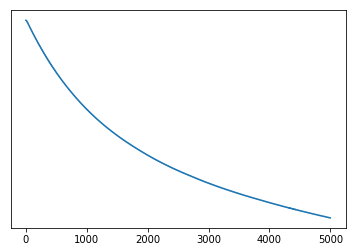

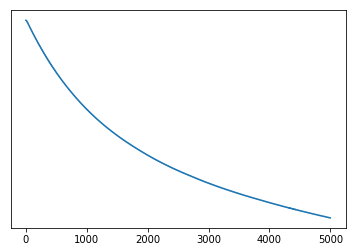

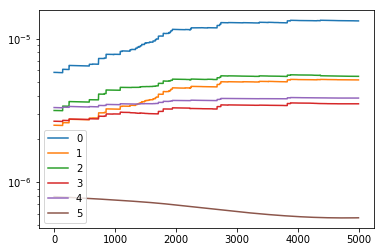

In [206]:
num_channels = [8]*5
output_depth = 1

totalupsample = 2**len(num_channels)
width = int(img_var.data.shape[2]/totalupsample)
height = int(img_var.data.shape[3]/totalupsample)

# shape = [1,num_channels[0], width,height]
# print("shape: ", shape)
# net_input = Variable(torch.zeros(shape))
# net_input.data.uniform_()
# net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
# net = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
# net.apply(init_normal)

# print(net)

mse_n, mse_t, ni, net, out_grads = fit(num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=5000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                        )


plt.semilogy(mse_n)
plt.show()

plt.semilogy(mse_t)
plt.show()

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

#### Plot loss function surface

In [207]:
### net_dir1 and net_dir2 are two deep decoder networks with random initialization. Since their parameters are initialized 
### randomly with normal distribution, they can be treated as two random directions. 

# net_dir1 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
# net_dir2 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)

net_coor = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
### Fix the weight and bias of last layer
net_coor[20][1].weight.data = net[20][1].weight.data
net_coor[20][1].bias.data = net[20][1].bias.data

### x and y-coordinate vector
x_coordinate = np.linspace(-2,2,31)
y_coordinate = np.linspace(-2,2,31)
X_coordinate, Y_coordinate = np.meshgrid(x_coordinate, y_coordinate)
Z = np.zeros(X_coordinate.shape)


### Calculate the loss function value given the x and y coordinate, and two directions net_dir1 & net_dir2
def loss_eval(x_coordinate,y_coordinate,z=1,net_coor=net_coor,net=net,net_dir1=net_dir1,net_dir2=net_dir2, \
              num_channels=num_channels,net_input=net_input,net_target=img_var):
#     net_coor = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
#     net_coor[20][1].weight.data = net[20][1].weight.data
#     net_coor[20][1].bias.data = net[20][1].bias.data
    for k in range(len(num_channels)):
        net_coor[4*k][1].weight.data = z*net[4*k][1].weight.data + x_coordinate*net_dir1[4*k][1].weight.data + \
        y_coordinate*net_dir2[4*k][1].weight.data
    net_out = net_coor(net_input) 
    return nn.MSELoss()(net_out,net_target)

def weight_init(m):
    torch.manual_seed(np.random.choice(100, 1))
    if isinstance(m, nn.Linear):
        xavier(m.weight.data)

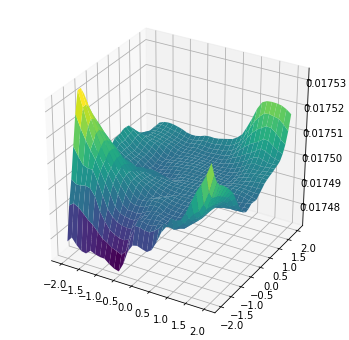

In [210]:
from matplotlib import gridspec

plot = plt.figure(figsize=(6,6))

for a1 in range(1): 
    ### Generate two deep decoder networks and get two random directions correspondingly
#     net_dir1 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
#     net_dir2 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    
    net_coor = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    net_coor[20][1].weight.data = net[20][1].weight.data
    net_coor[20][1].bias.data = net[20][1].bias.data

    for ii in range(len(x_coordinate)):
        for jj in range(len(y_coordinate)):
            Z[ii,jj] = loss_eval(X_coordinate[ii,jj],Y_coordinate[ii,jj], net=net, net_dir1=net_dir1, net_dir2=net_dir2, net_target=img_var)
            
    fig = plot.add_subplot(1, 1, a1+1, projection='3d')
    fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    
# plot = plot.get_figure()
# plot.savefig('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Deep Decoder_Linear.pdf')

We can see that when (x_coordinate, y_coordinate) = (2,-2), the loss function value is smaller than the that of (x_coordinate, y_coordinate) = (0,0). we can also find when (x_coordinate, y_coordinate) = (3,-3), loss function is even smaller. So, next, we start the initialization from (x_coordinate, y_coordinate) = (3,-3)

In [211]:
loss_eval(-3,-3, net=net, net_dir1=net_dir1, net_dir2=net_dir2, net_coor=net_coor, net_target=img_var)

tensor(0.0169, grad_fn=<MseLossBackward>)

In [212]:
net_new_initial = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)

net_new_initial[20][1].weight.data = net[20][1].weight.data
net_new_initial[20][1].bias.data = net[20][1].bias.data

for k in range(len(num_channels)):
    net_new_initial[4*k][1].weight.data = net[4*k][1].weight.data - 3*net_dir1[4*k][1].weight.data - 3*net_dir2[4*k][1].weight.data
    
net_out = net_new_initial(net_input) 
nn.MSELoss()(net_out,img_var)

tensor(0.0169, grad_fn=<MseLossBackward>)

#### Training net_new_initial

input provided
optimize with SGD 0.05


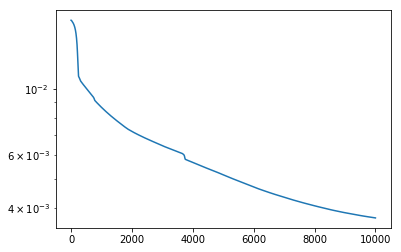

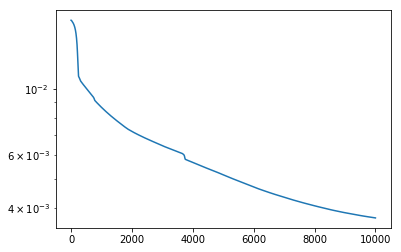

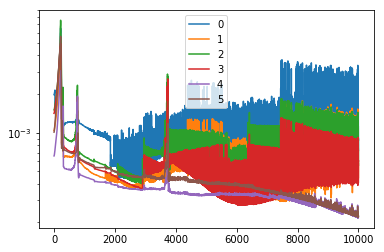

In [186]:
net_new = copy.deepcopy(net_new_initial)

mse_n, mse_t, ni, net_new, out_grads = fit(num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=10000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net_new,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                        )


plt.semilogy(mse_n)
plt.show()

plt.semilogy(mse_t)
plt.show()

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

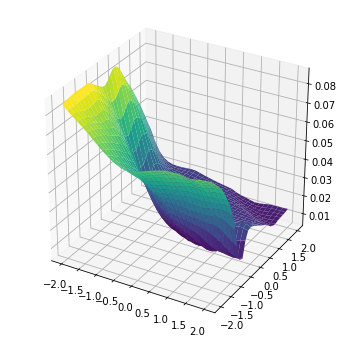

In [187]:
from matplotlib import gridspec

plot = plt.figure(figsize=(6,6))

for a1 in range(1): 
    ### Generate two deep decoder networks and get two random directions correspondingly
    net_dir3 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    net_dir4 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    
    net_coor2 = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    net_coor2[20][1].weight.data = net_new[20][1].weight.data
    net_coor2[20][1].bias.data = net[20][1].bias.data

    for ii in range(len(x_coordinate)):
        for jj in range(len(y_coordinate)):
            Z[ii,jj] = loss_eval(X_coordinate[ii,jj],Y_coordinate[ii,jj], net=net_new, net_coor=net_coor2, net_dir1=net_dir3, net_dir2=net_dir4, net_target=img_var)
            
    fig = plot.add_subplot(1, 1, a1+1, projection='3d')
    fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')

### Output the network State_dict

In [192]:
state_dict = net.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_Model_State.t7')

state_dict = net_new_initial.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_new_initial_Model_State.t7')

state_dict = net_dir1.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir1_Model_State.t7')

state_dict = net_dir2.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir2_Model_State.t7')

state_dict = net_dir3.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir3_Model_State.t7')

state_dict = net_dir4.state_dict()
net_state = {'state_dict': state_dict}
torch.save(net_state, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Net_dir4_Model_State.t7')

torch.save(net_input, 'C:/Reinhard Research Projects/ICLR workshop/Visualize Network/net_input.pt')
